------------------------------------------------------------------------------
# Segmentation of EM images 
------------------------------------------------------------------------------

**Description of the notebook**

Segment EM images into myelin, axons and background.

This code should be modified to perform the binary segmentation of the myelin using topological losses.

The data are included in a 'data' directory you have to create (on your Drive if you are using Google Colab). This directory also contains 6 directories:
* TRAIN (EM images used for training)
* VALIDATION (EM images used for validation)
* TEST (EM images used for test)
* SEGMENT_TRAIN (3-class manual segmentations used for training)
* SEGMENT_VALIDATION (3-class manual segmentations used for validation)
* SEGMENT_TEST (3-class manual segmentations used for test)

The database distribution used in [1] is provided in the file distribution.csv

**References**
* [1] Le Couedic, T., Caillon, R., Rossant, F., Joutel, A., Urien, H., & Rajani, R. M. (2020, November). Deep-learning based segmentation of challenging myelin sheaths. In 2020 Tenth International Conference on Image Processing Theory, Tools and Applications (IPTA) (pp. 1-6). IEEE.

## Installations

In [ ]:
# Install Monai
!python -c "import monai" || pip install -q "monai[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
print("jjj")

## Imports

In [ ]:
#System imports
import json
import os
import time
# from google.colab import drive
from glob import glob

#Package imports
from scipy import ndimage as ndi
from PIL import Image
from typing import Sequence, Union
import matplotlib.pyplot as plt
import numpy as np
import monai
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    Rotate90,
    ScaleIntensity,
    ToTensor,
    RandFlip
)
from monai.utils import set_determinism
from monai.data import ArrayDataset
from monai.transforms.compose import Transform
from skimage.transform import resize
import torch
print_config()
print("7777")

## Drive mounting (if using Google Colab)

In [ ]:
#Mount the drive
# drive.mount('/content/drive')

## User Inputs

**Needed inputs**
* data_dir: str (data directory)
* batch_size: int (the size of the training batches)
* nb_channels: int (the number of channels in the input image)
* lr: float (the learning rate used during training) 
* output_dim: list of integers (the dimension of the output image)
* val_interval: integer (compute validation loss value every val_interval iterations)
* labels: list of integers (the labels to select)
* outdir: str (the output directory) 

In [ ]:
# Input parameters
args = {
# 'data_dir' : '/content/drive/My Drive/projet_myeline/data',
'data_dir' : './data',
'batch_size' : 20,
'nb_channels' : 1,
'nb_epochs' : 50,
'lr' : 0.1,
'output_dim' : [448, 672],
'val_interval' : 1,
# 'labels' : [1, 2, 3],
'labels' : [2],
'outdir' : './results/test'
}

## Classes and functions

In [ ]:
def my_round(x):
  """ Round a float value

    Parameters
    ----------
    x: float (mandatory)
        the input value

    Returns
    -------
    x_out: float
        the output rounded value

   Command:
   -------
   x_out = my_round(x)
   """

  #Round
  x_out = np.round(x * 100) / 100
  return x_out

In [ ]:
def create_data_dict(imsdir, masksdir):
  """ Load the images and their associated manual segmentations,
  and put them into a dictionary

    Parameters
    ----------
    imsdir: str (mandatory)
        the data full path
    masksdir: str (mandatory)
        the manual segmentation full path  

    Returns
    -------
    data_dict: dictionary
        the dictionary associated images with their manual segmentation

   Command:
   -------
   data_dict = create_data_dict(imsdir, masksdir)
   """
  data_dict = {}
  impaths = []
  gtpaths = []
  for impath in sorted(glob(os.path.join(imsdir, '*.tif'))):
      imname = os.path.basename(impath).split('.')[0]
      gtfile = imname + '_segmented.png'

      #Convert the tif into png if necessary
      im_png_path = os.path.join(imsdir, imname + '.png')
      im_arr = np.array(Image.open(impath))
      im = Image.fromarray(im_arr)
      im.save(im_png_path)

      #Keep the image only if it is associated with a segmentation    
      if not os.path.exists(os.path.join(masksdir, gtfile)):
        print('Warning : no segmentation for {0}'.format(imname))
      else:         
          impaths.append(im_png_path)
          gtpaths.append(os.path.join(masksdir, gtfile))
  data_dict = {'image':impaths, 'label':gtpaths} 
  
  return data_dict

In [ ]:
class seg2Dtoseg3D(Transform):
    """
    Convert a 2D segmentation (size s1 x s2) with n labels to an image of
    dimension s1 x s2 x n image, 
    each channel being the binary image of the associated label
    
    Parameters
    ----------
    labels: list of integers (mandatory)
        the list of the n needed label values

    Returns
    -------
    output_arr: array
        the output array of dimension s1 x s2 x n

   Command:
   -------
   data_dict = create_data_dict(imsdir, masksdir)

    """

    def __init__(
        self,
        labels: Union[Sequence[int], int],
    ) -> None:
        self.labels = labels

    def __call__(self,
                 img: np.ndarray) -> np.ndarray:
        result = []
        for class_id in self.labels:
            if len(self.labels) == 1:
                result.append(img != class_id)   
         
            result.append(img == class_id)

            # Output array
            out_arr = np.stack(result, axis=0).astype(np.float32)
        return out_arr

In [ ]:
class my_resample(Transform):
    """
    Resample an image of size s1 x s2 into an image of size new_s1 x new_s2, 
    possibly with new_s1 != new_s2

    Parameters
    ----------
    pixdim: list of integers [s1_new, s2_new] (mandatory)
        the dimension of the output image 

    mode: str ('nn' or 'bilinear')
      the method used for interpolation (nearest-neighbor or bilinear) 

    Returns
    -------
    output_arr: array
        the output array of dimension s1_new x s2_new x n

   Command:
   -------
   data_dict = create_data_dict(imsdir, masksdir)

    """

    def __init__(
        self,
        pixdim: Union[Sequence[int], int],
        mode: str,
    ) -> None:
        self.pixdim = pixdim
        self.mode = mode

    def __call__(self, img: np.ndarray) -> np.ndarray:

      #Choose the resample method
      if self.mode == 'nn':
        order = Image.NEAREST
      elif self.mode == 'bilinear':
        order = Image.BILINEAR

      #Resample using PIL
      pil_img = Image.fromarray(img)
      output_arr = np.array(pil_img.resize((self.pixdim[1],
                                            self.pixdim[0]),
                                            order))

      return output_arr

## Reproducibility

In [ ]:
# Make the code reproducible (to get the same result at each run)
set_determinism(seed=0)

## Data preparation

In [ ]:
#Create output directory if needed
if not os.path.isdir(args['outdir']):
    os.makedirs(args['outdir'])

#Create logs output directory if needed
logsdir = os.path.join(args['outdir'], 'logs')
if not os.path.isdir(logsdir):
    os.makedirs(logsdir)   

#Create training output directory if needed
traindir = os.path.join(args['outdir'], 'train')
if not os.path.isdir(traindir):
    os.makedirs(traindir)   

#Create test output directory if needed
testdir = os.path.join(args['outdir'], 'test')
if not os.path.isdir(testdir):
    os.makedirs(testdir)  

In [ ]:
#Get the EM images and associated segmentations directories

im_train_dir = os.path.join(args['data_dir'], 'TRAIN')
label_train_dir = os.path.join(args['data_dir'], 'SEGMENT_TRAIN')

im_valid_dir = os.path.join(args['data_dir'], 'VALID')
label_valid_dir = os.path.join(args['data_dir'], 'SEGMENT_VALID')

im_test_dir = os.path.join(args['data_dir'], 'TEST')
label_test_dir = os.path.join(args['data_dir'], 'SEGMENT_TEST')

# Display database statistics
print('{0} training images'.format(len(os.listdir(im_train_dir))))
print('{0} training manual segmentations'.format(len(os.listdir(label_train_dir))))
print('{0} validation images'.format(len(os.listdir(im_valid_dir))))
print('{0} validation manual segmentations'.format(len(os.listdir(label_valid_dir))))
print('{0} test images'.format(len(os.listdir(im_test_dir))))
print('{0} test manual segmentations'.format(len(os.listdir(label_test_dir))))

In [39]:
#Create the training/validation and test data dictionaries
train_data_dict = create_data_dict(im_train_dir, label_train_dir)
valid_data_dict = create_data_dict(im_valid_dir, label_valid_dir)
test_data_dict = create_data_dict(im_test_dir, label_test_dir)

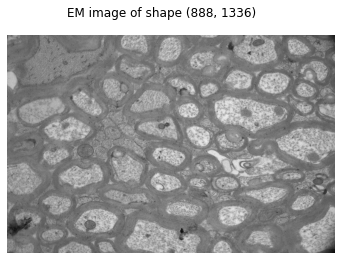

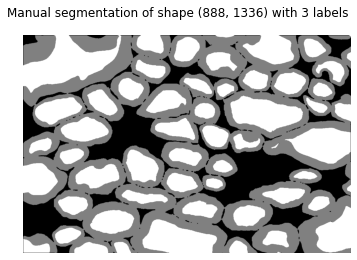

In [40]:
#Display an image and its associated manual segmentation
impaths = train_data_dict['image']
im_arr = np.array(Image.open(train_data_dict['image'][0]))
gt_arr = np.array(Image.open(train_data_dict['label'][0]))

fig, ax = plt.subplots(figsize=(10, 4));
ax.imshow(im_arr / np.max(im_arr), cmap='gray');
fig.suptitle('EM image of shape {0}'.format(im_arr.shape));
ax.axis('off');

fig, ax = plt.subplots(figsize=(10, 4));
ax.imshow(gt_arr / np.max(gt_arr), cmap='gray');#
fig.suptitle('Manual segmentation of shape {0}'
             ' with {1} labels'.format(gt_arr.shape,
                                       len(np.unique(gt_arr))));
ax.axis('off');

In [41]:
#Get parameters for the Unet
nb_classes = len(args['labels'])
if nb_classes == 1:
  nb_classes += 1
dimension = len(im_arr.shape)
class_ids = np.unique(gt_arr)
print('{0} classes, {1}D image'.format(nb_classes, dimension))

2 classes, 2D image


# Training

In [42]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        my_resample(pixdim=args['output_dim'], mode='bilinear'),
        ScaleIntensity(),
        AddChannel(),
        RandFlip(prob=0.5, spatial_axis=0),
        RandFlip(prob=0.5, spatial_axis=1),
        ToTensor(),
    ]
)

train_segtrans = Compose(
    [
        LoadImage(image_only=True, dtype=np.uint8),
        my_resample(pixdim=args['output_dim'], mode='nn'), 
        seg2Dtoseg3D(labels=args['labels']), 
        RandFlip(prob=0.5, spatial_axis=0),
        RandFlip(prob=0.5, spatial_axis=1),
        ToTensor(),
    ])

val_imtrans = Compose([LoadImage(image_only=True), 
                       my_resample(pixdim=args['output_dim'], mode='bilinear'),
                       ScaleIntensity(), 
                       AddChannel(), 
                       ToTensor()])

val_segtrans = Compose([LoadImage(image_only=True), 
                        my_resample(pixdim=args['output_dim'], mode='nn'),
                        seg2Dtoseg3D(labels=args['labels']), 
                        ToTensor()])

In [43]:
# create a training data loader
train_ds = ArrayDataset(train_data_dict['image'], train_imtrans, 
                        train_data_dict['label'], train_segtrans)

In [44]:
train_loader = DataLoader(train_ds,
                          batch_size=args['batch_size'],
                          shuffle=True, 
                          num_workers=2,
                          pin_memory=torch.cuda.is_available())

In [45]:
# create a validation data loader
val_ds = ArrayDataset(valid_data_dict['image'], val_imtrans, 
                        valid_data_dict['label'], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, 
                          num_workers=2,
                          pin_memory=torch.cuda.is_available())

In [46]:
#Select the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the network architecture
model = monai.networks.nets.UNet(
    dimensions=dimension,
    in_channels=args['nb_channels'],
    out_channels=nb_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

#Define the loss function = mean Dice of the labels, background excluded
loss_function = DiceLoss(softmax=True)

#Choose an optimizer
optimizer = torch.optim.SGD(model.parameters(), args['lr'])  

# Training

In [47]:
# start a typical PyTorch training
train_mean_imlosses = []
valid_mean_imlosses = []
train_resume = []

#Go through each epoch
for epoch in range(args['nb_epochs']):
   
    #Save comments
    comment = '-' * args['nb_epochs']
    #print(comment) 
    train_resume.append(comment)

    comment = 'epoch {0}/{1} '.format(epoch + 1, args['nb_epochs'])
    print(comment) 
    train_resume.append(comment)

    #Initialize training paramaters
    model.train()
    sum_epoch_imloss = 0
    nb_step_ims = 0

    #Go through each batch
    for cnt_batch, batch_data in enumerate(train_loader):
        #Get the batch images and manual segmentations
        ims_torch = batch_data[0].to(device)
        gts_torch = batch_data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Learn (forward)
        preds_torch = model(ims_torch)

        #Compute the loss 
        loss = loss_function(preds_torch, gts_torch)

        #Backward + optimize
        loss.backward()
        optimizer.step()

        #Save batch parameters
        nb_batch_ims = ims_torch.shape[0]
        sum_epoch_imloss += loss.item() * nb_batch_ims
        nb_step_ims += nb_batch_ims
        epoch_len = len(train_ds) // train_loader.batch_size

        #Save comments
        comment = '{0}/{1}, train loss = {2}'.format(cnt_batch + 1, epoch_len,
                                                     my_round(loss.item()))
        #print(comment) 
        train_resume.append(comment)
    
    #Compute and save the mean epoch loss
    mean_imloss = sum_epoch_imloss / nb_step_ims
    train_mean_imlosses.append(mean_imloss)

    #Save comments
    comment = 'epoch {0} average batch loss {1}'.format(epoch + 1,
                                                        my_round(mean_imloss))
    #print(comment) 
    train_resume.append(comment) 

    if (epoch + 1) % args['val_interval'] == 0:
        model.eval()
        with torch.no_grad():
            sum_epoch_imloss = 0
            nb_step_ims = 0
            for cnt_val, val_data in enumerate(val_loader):
                # Get the validation images and manual segmentations
                val_images = val_data[0].to(device)
                val_labels = val_data[1].to(device)
                
                #Compute the validation loss
                nb_batch_ims = val_images.shape[0]
                nb_step_ims += nb_batch_ims
                outputs = model(val_images)
                loss = loss_function(outputs, val_labels)
                sum_epoch_imloss += loss.item() * nb_batch_ims

            #Compute and save the mean epoch loss
            mean_imloss = sum_epoch_imloss / nb_step_ims
            valid_mean_imlosses.append(mean_imloss)  

#Save the last model
torch.save(model.state_dict(), os.path.join(args['outdir'], 'final_model.pth'))

epoch 1/50 
epoch 2/50 
epoch 3/50 
epoch 4/50 
epoch 5/50 
epoch 6/50 
epoch 7/50 
epoch 8/50 
epoch 9/50 
epoch 10/50 
epoch 11/50 
epoch 12/50 
epoch 13/50 
epoch 14/50 
epoch 15/50 
epoch 16/50 
epoch 17/50 
epoch 18/50 
epoch 19/50 
epoch 20/50 
epoch 21/50 
epoch 22/50 
epoch 23/50 
epoch 24/50 
epoch 25/50 
epoch 26/50 
epoch 27/50 
epoch 28/50 
epoch 29/50 
epoch 30/50 
epoch 31/50 
epoch 32/50 
epoch 33/50 
epoch 34/50 
epoch 35/50 
epoch 36/50 
epoch 37/50 
epoch 38/50 
epoch 39/50 
epoch 40/50 
epoch 41/50 
epoch 42/50 
epoch 43/50 
epoch 44/50 
epoch 45/50 
epoch 46/50 
epoch 47/50 
epoch 48/50 
epoch 49/50 
epoch 50/50 


In [48]:
##Save comments
logsdir="./comments"
with open(os.path.join(logsdir, 'train_resume.txt'), 'w') as text_file:
    for comment in train_resume:
        text_file.write(comment)
        text_file.write('\n')

In [49]:
#Save input arguments
with open(os.path.join(logsdir, 'inputs.json'), 'wt') as open_file:
    json.dump(args, open_file, indent=2)

NameError: name 'train_mean_imlosses' is not defined

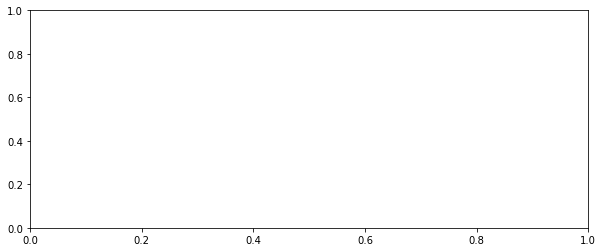

In [5]:
#Get the training epochs
traindir="./training_loss"
train_epochs = list(range(1, args['nb_epochs'] + 1))

#Get the validation epochs
val_epochs = train_epochs[args['val_interval']-1::args['val_interval']]

#Plot the batch training loss 
fig, ax = plt.subplots(figsize=(10, 4));
ax.plot(train_epochs, train_mean_imlosses, label='training')
ax.plot(val_epochs, valid_mean_imlosses, label='validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training loss')
ax.legend(loc='upper left')
fig.suptitle('Mean image training loss');
ax.set_xlim(1, args['nb_epochs'])
ax.set_ylim(0, 1)
fig.savefig(os.path.join(traindir, 'im_train_loss.png'))

## Test

In [52]:
#Select a model 
trained_model = monai.networks.nets.UNet(
    dimensions=dimension,
    in_channels=args['nb_channels'],
    out_channels=nb_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

trained_model.load_state_dict(torch.load(os.path.join(args['outdir'], 
                                                      'final_model.pth')));

In [53]:
#Test image transforms
test_imtrans = Compose([LoadImage(image_only=True), 
                        my_resample(pixdim=args['output_dim'], mode='bilinear'),               
                        ScaleIntensity(), 
                        AddChannel(), 
                        ToTensor()])

#Test segmentation transforms
test_segtrans = Compose([LoadImage(image_only=True), 
                        my_resample(pixdim=args['output_dim'], mode='nn'),   
                        seg2Dtoseg3D(labels=args['labels']), 
                        ToTensor()])

In [54]:
# create the test data loader
test_ds = ArrayDataset(test_data_dict['image'], test_imtrans, 
                       test_data_dict['label'], test_segtrans)
                       
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, 
                          num_workers=2,
                          pin_memory=torch.cuda.is_available())

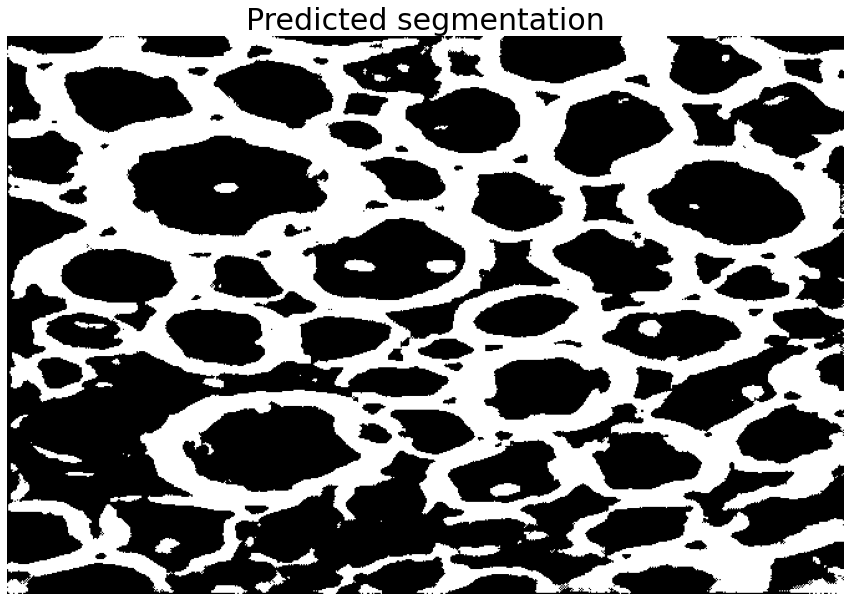

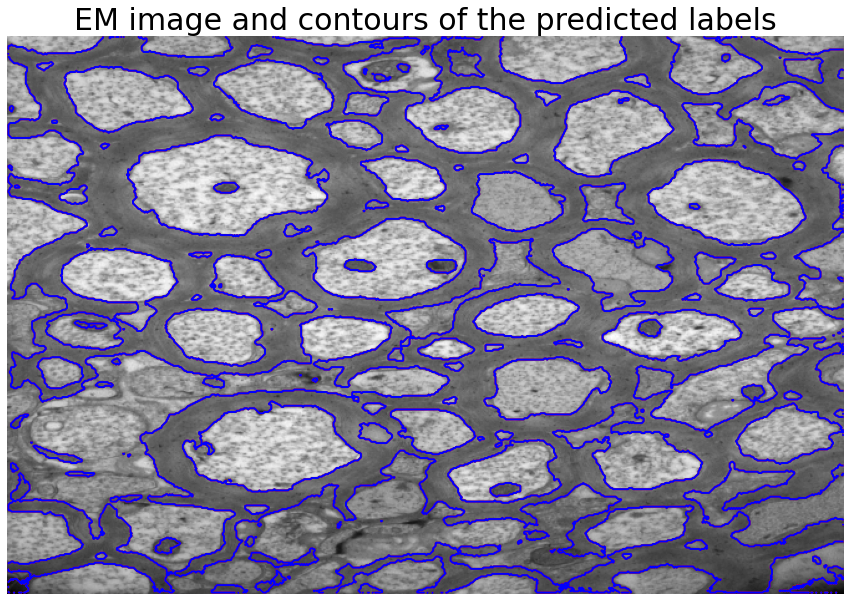

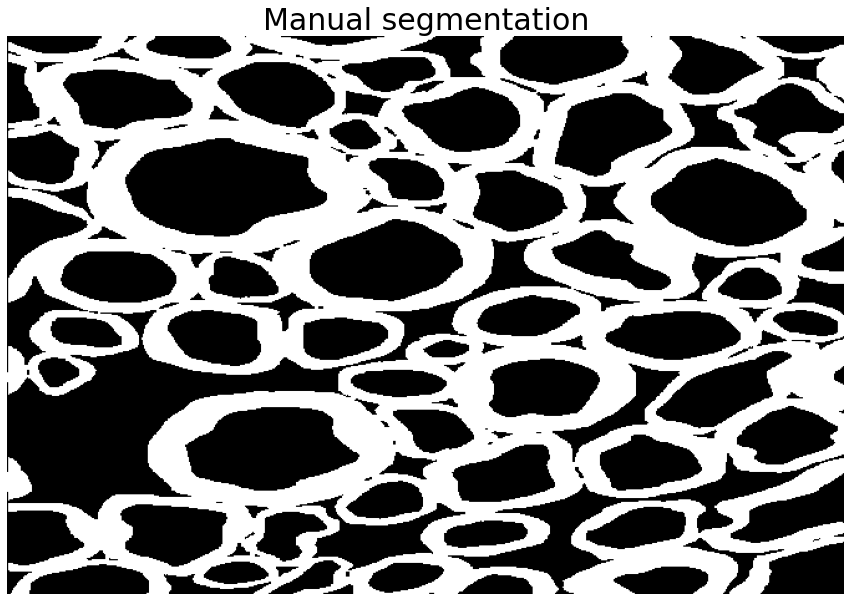

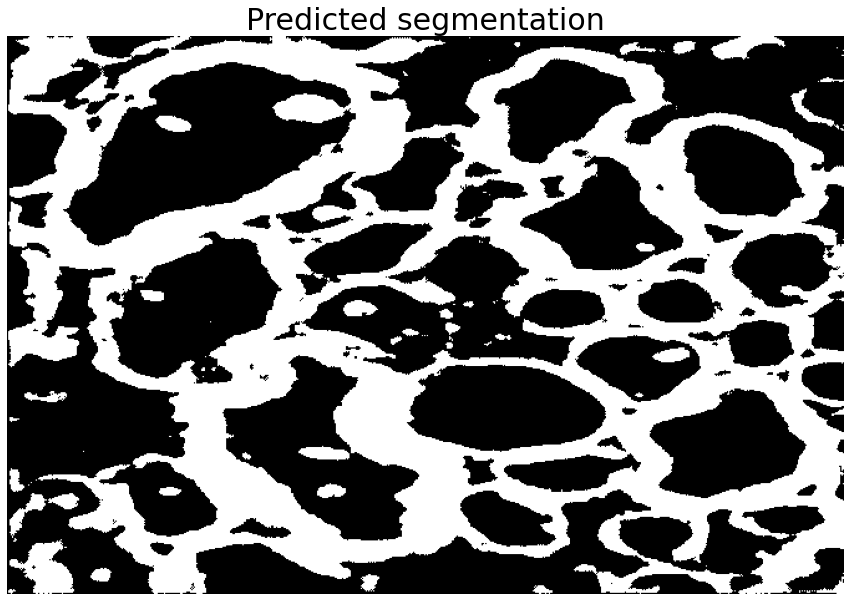

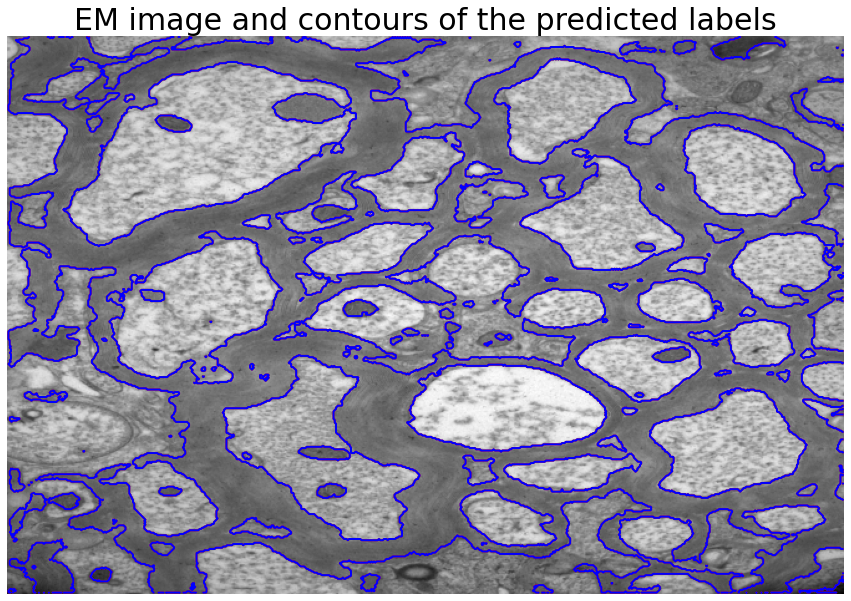

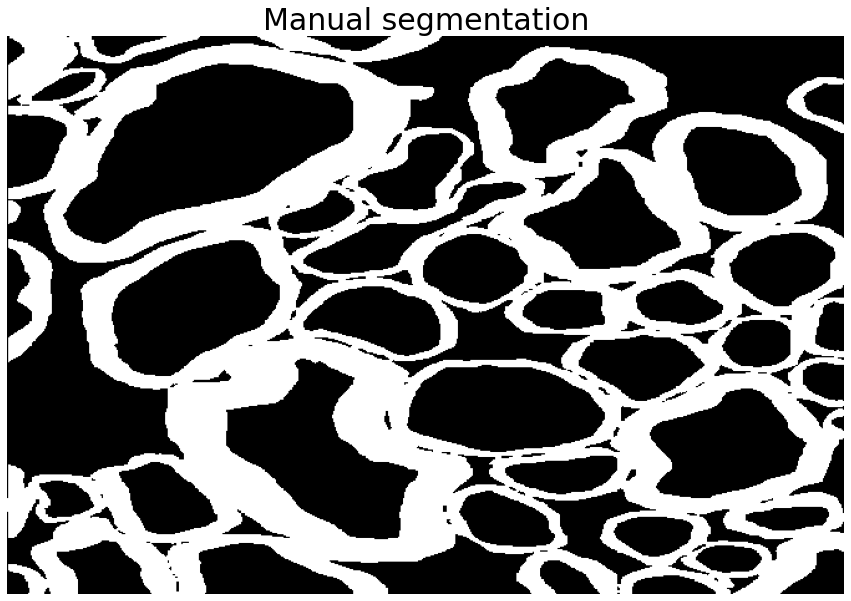

In [55]:
#Test the model on unseen images
tot_dices = []
se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

trained_model.eval()
with torch.no_grad():
  for cnt_test, test_data in enumerate(test_loader):
    
    #Load each couple of image/manual segmentation
    im_torch = test_data[0].to(device)
    gt_torch = test_data[1].to(device)
    
    #Apply the model to the unknown image
    pred_torch = trained_model(im_torch)

    #Hard automatic segmentation
    seg_arr = pred_torch[0, :, :, :].detach().cpu()
    seg_arr = np.argmax(seg_arr.numpy(), axis=0)
    seg_arr += 1

    #Hard manual segmentation
    gt_arr = gt_torch[0, :, :, :].detach().cpu()
    gt_arr = np.argmax(gt_arr.numpy(), axis=0)
    gt_arr += 1

    #Predicted labels
    pred_labs = np.unique(seg_arr)
    pred_labs = pred_labs[pred_labs > 0]

    #Display the results
    im_arr = im_torch[0, 0, :, :].detach().cpu()

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(seg_arr, cmap='gray');
    ax.axis('off');  
    ax.set_title('Predicted segmentation', fontsize=30)
    fig.savefig(os.path.join(testdir, 'test{0}_pred.png'.format(cnt_test)))

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(im_arr, cmap='gray');
    for label, color in zip(pred_labs, ['r', 'b', 'k']):
      ax.contour(seg_arr==label, [0.5], colors=color, linewidths = [2, 2])
    ax.axis('off');
    ax.set_title('EM image and contours of the predicted labels',
                 fontsize=30)
    fig.savefig(os.path.join(testdir, 'test{0}_im+pred.png'.format(cnt_test)))

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(gt_arr, cmap='gray');
    ax.axis('off');  
    ax.set_title('Manual segmentation', fontsize=30)
    fig.savefig(os.path.join(testdir, 'test{0}_gt.png'.format(cnt_test)))

6 3
['test0_pred.png', 'test0_im+pred.png', 'test1_pred.png', 'test1_gt.png', 'test0_gt.png', 'test1_im+pred.png']


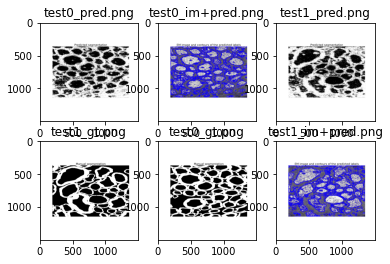

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

listdir="./test_unseen_images"

list_numbers=len(os.listdir(listdir))
print(list_numbers,int(list_numbers /int(np.sqrt(list_numbers))))
lists=os.listdir(listdir)
print(lists)

# fig, ax = plt.subplots(figsize=(int(list_numbers/int(np.sqrt(list_numbers))), int(np.sqrt(list_numbers))))
row=int(int(np.sqrt(list_numbers)))
rank=int(list_numbers/int(np.sqrt(list_numbers)))
plt.figure()
i=1
for list in lists:
    plt.subplot(row,rank,i)
    image_dir="test_unseen_images/"+list
    img = mpimg.imread(image_dir)
    plt.title(list)
    plt.imshow(img)
    i=i+1
plt.show()